<a href="https://colab.research.google.com/github/hypnopump/egnn-pytorch/blob/main/examples/egnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get env ready

In [1]:
!pip install sidechainnet proDy einops
!git clone https://github.com/hypnopump/egnn-pytorch
!git clone https://github.com/hypnopump/geometric-vector-perceptron
!nvidia-smi

fatal: destination path 'egnn-pytorch' already exists and is not an empty directory.
fatal: destination path 'geometric-vector-perceptron' already exists and is not an empty directory.
Thu Mar 25 16:02:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |       

In [2]:
import torch
torch.__version__

'1.8.0+cu101'

In [3]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html


In [4]:
# get CASP7 data copied from drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
!mkdir sidechainnet_data
!cp drive/MyDrive/sidechainnet_casp7_30.pkl sidechainnet_data/sidechainnet_casp7_30.pkl

mkdir: cannot create directory ‘sidechainnet_data’: File exists


## Start code

### Load model and data

In [6]:
import os
import sys
import time

sys.path.append("geometric-vector-perceptron/geometric_vector_perceptron")
sys.path.append("geometric-vector-perceptron/examples")
sys.path.append("egnn-pytorch/egnn_pytorch")

In [7]:
import torch
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom model
from egnn_pytorch import *
from geometric_vector_perceptron import *
# custom utils
from data_handler import *
from data_utils import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [8]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

In [10]:
# MIN_LEN = 70
MAX_LEN = 250
MAX_PROTS = 360

In [11]:
# check dataloader works
dataloaders_ = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB, max_len=MAX_LEN, verbose=0)\
                         for i in tqdm(range(3))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib"

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


In [12]:
NEEDED_INFO = {"cutoffs": ["15_closest"],
               "bond_scales": [1, 2],
               "aa_pos_scales": [1,2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
               "bb_norms_atoms": [0.5] # will encode 3 vectors with this
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq, mask, id = train_examples_storer[-1] 
NEEDED_INFO["seq"] = seq[:-padding_seq or None]
NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)


# encode as needed
encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
# add position coords
cloud_mask = scn_cloud_mask(seq)
if padding_seq:
    cloud_mask[-padding_seq:] = 0.
cloud_mask = cloud_mask.bool()
flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')

x = torch.cat( [ true_coords[flat_cloud_mask], x ], dim=-1 )

### adjust for egnn: 
# 1. remove vectors
# 2. remove scalars for distance
embedd_info["point_n_scalars"] -= 2*len(NEEDED_INFO["aa_pos_scales"])+1
embedd_info["point_n_scalars"] -= 2*len(NEEDED_INFO["atom_pos_scales"])+1
embedd_info["point_n_scalars"] -= 2*len(NEEDED_INFO["dist2ca_norm_scales"])+1
embedd_info["point_n_scalars"] -= 3 * ( 2*len(NEEDED_INFO["bb_norms_atoms"])+1 )
embedd_info["point_n_vectors"] = 0
embedd_info["bond_n_scalars"] -= 2*len(NEEDED_INFO["bond_scales"])+1
embedd_info["bond_n_vectors"] = 0

embedd_info

{'bond_embedding_nums': [2],
 'bond_n_scalars': 1,
 'bond_n_vectors': 0,
 'point_n_scalars': 2,
 'point_n_vectors': 0}

### Train

In [13]:
# define model
model = EGNN_Sparse_Network(n_layers=4,
                            feats_dim=2, pos_dim = 3,
                            edge_attr_dim = 1, m_dim = 16,
                            fourier_features = 4,
                            embedding_nums=[36,20], embedding_dims=[16,16],
                            edge_embedding_nums=[2], edge_embedding_dims=[2],
                            update_coors=True, update_feats=True, norm_feats=False,
                            norm_rel_coors=False, norm_coor_weights=False,
                            recalc=False, verbose=False)

In [14]:
model = model.to(device) # .double()

In [15]:
noise = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [67]:
model.train()

# info records
baseline_losses = []
epoch_losses    = []
tac    = time.time()
# training run params
max_seq_len = MAX_LEN # 120
iteration   = 0
n_per_iter  = MAX_PROTS # 400
for ep in range( 1 ): # 1*n_per_iter
    # delete useless data from prev iter - but not in last one
    if ep > 0:
        del true_coords, angles, edge_index, edge_attrs
        del target_coords, pred_coords, base_coords
        del encoded, target_aligned, pred_aligned
        gc.collect()
        
        
    # get model sizes from encoded protein
    seq, true_coords, angles, padding_seq, mask, pid = get_prot(dataloader_=dataloaders_,
                                                           vocab_=VOCAB, 
                                                           max_len=MAX_LEN, 
                                                           verbose=0)
    NEEDED_INFO["seq"] = seq[:-padding_seq or None]
    NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)
    
    # avoid seqs above limit
    if len(seq) > max_seq_len: 
        continue
        
    # pass to device
    true_coords = true_coords.to(device) # .double()
    angles = angles.to(device)           # .double()

    # encode as needed
    encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
    x, edge_index, edge_attrs, embedd_info = encoded
    # add position coords - better mask accounting for missing atoms
    cloud_mask_naive = scn_cloud_mask(seq).bool()
    cloud_mask = scn_cloud_mask(seq, coords=true_coords).bool()
    if padding_seq:
      cloud_mask[-padding_seq:] = 0.
    # cloud is all points, chain is all for which we have labels
    chain_mask = mask.unsqueeze(-1) * cloud_mask
    flat_chain_mask = rearrange(chain_mask, 'l c -> (l c)')
    flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')
    # slice useless norm and vector embeddings
    masked_coords = (true_coords + noise * 2*(torch.rand_like(true_coords)-0.5) )[flat_cloud_mask]

    #############
    # MASK EDGES AND NODES ACCOUNTING FOR SCN MISSING ATOMS
    #############
    # NODED
    x = torch.cat( [ masked_coords, x[:, -2:][cloud_mask[cloud_mask_naive]] ], dim=-1 )
    # EDGES: delete all edges with masked-out atoms
    # masked out: 0s -> -1 * (-1) -> 1 -> bool()
    to_mask_edges = torch.zeros(edge_index.shape[-1])
    masked_out_atoms = (-1*(cloud_mask[cloud_mask_naive].float() - 1)).nonzero()
    sample_index = edge_index.cpu()
    for atom in masked_out_atoms:
        to_mask_edges += (sample_index==atom).sum(dim=0)
    to_mask_edges = torch.logical_not(to_mask_edges.bool())
    edge_index = edge_index[:, to_mask_edges]
    edge_attrs = edge_attrs[to_mask_edges, :]

    if masked_out_atoms.shape[0] > 0: # correct indexes of atoms
        edge_index -= (edge_index.unsqueeze(-1) > masked_out_atoms.squeeze().to(edge_index.device)).sum(dim=-1)
    # continue
    #
    edge_attrs = edge_attrs[:, -1:]
    batch = torch.tensor([0 for i in range(x.shape[0])], device=device).long()
    
    if torch.amax(edge_index) >= x.shape[0]:
      print("wtf, breaking, debug, index out of bounds")
      break

    # predict
    preds = model.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                          recalc_edge=None, verbose = False)
    
    # MEASURE ERROR - format pred and target
    target_coords = true_coords[flat_cloud_mask].clone()
    pred_coords   = preds[:, :3]
    base_coords   = x[:, :3]
    
    # option 2: loss is RMSD on reconstructed coords  // align - sometimes svc fails - idk why
    try:
        pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)

        loss = ( (pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean() 
    except:
        pred_aligned, target_aligned = None, None
        print("svd failed convergence, ep:", ep)
        loss = ( (pred_coords - target_coords)[flat_chain_mask[flat_cloud_mask]]**2 ).mean()
    # measure error
    loss_base = ((base_coords - target_coords)**2).mean() 
    # not aligned: # loss = ((pred_coords - target_coords)**2).mean()**0.5 
    
    # back pass
    optimizer.zero_grad()
    loss.backward(create_graph=True)
    optimizer.step()
    
    # records / prints
    iteration += 1
    epoch_losses.append( loss.item() )
    baseline_losses.append( loss_base.item() )
    if iteration % 10 == 1:
        tic = time.time()
        print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration, n_per_iter,
                                                                                  epoch_losses[-1],
                                                                                  baseline_losses[-1],
                                                                                  tic-tac))
        tac = time.time()
        if iteration % n_per_iter == 1:
            print("---------------------------------")

    # quality control for too dispar coordinates
    dist_mat = torch.cdist(masked_coords, masked_coords, p=2)
    argkmax = torch.topk(-dist_mat, k=15, dim=-1).values
    if -argkmax.amin() > 35: 
      print("wtf too large. breaking. debug: ", -argkmax.amin())
      break
    else: 
      pass # print("amax is", -argkmax.amin())


BATCH: 1 / 360, loss: 0.06671558320522308, baseline_loss: 0.3273535966873169, time: 0.3626115322113037
---------------------------------


In [68]:
# expected loss without denoising - recorded inside training loop
np.mean(baseline_losses) 

0.3273535966873169

### Train plot

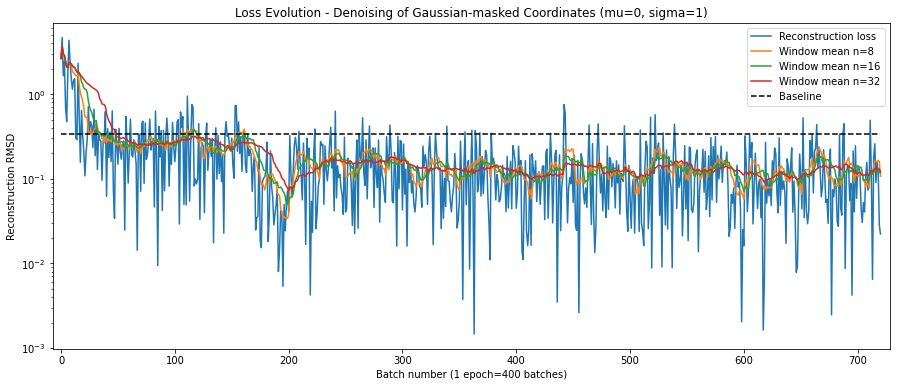

In [55]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(min(window, len(epoch_losses))) ] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses)) * np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
plt.yscale("log")
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number (1 epoch=400 batches)")
plt.legend()
plt.show()

In [79]:
print("MSE between masked coords: ", ((base_coords - target_coords)**2).mean() )

MSE between masked coords:  tensor(0.3274, device='cuda:0')


In [80]:
# rotate / align
pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)
print("MSE between reconstructed coords: ", ((pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2).mean() )

MSE between reconstructed coords:  tensor(0.0667, device='cuda:0', grad_fn=<MeanBackward0>)


### Protein plots

In [81]:
def build_scaffolds_from_scn_angles(seq, angles, coords=None, device="auto"):
    """ Builds scaffolds for fast access to data
        Inputs: 
        * seq: string of aas (1 letter code)
        * angles: (L, 12) tensor containing the internal angles.
                  Distributed as follows (following sidechainnet convention):
                  * (L, 3) for torsion angles
                  * (L, 3) bond angles
                  * (L, 6) sidechain angles
        * coords: (L, 3) sidechainnet coords. builds the mask with those instead
                  (better accuracy if modified residues present).
        Outputs:
        * cloud_mask: (L, 14 ) mask of points that should be converted to coords 
        * point_ref_mask: (3, L, 11) maps point (except n-ca-c) to idxs of
                                     previous 3 points in the coords array
        * angles_mask: (2, L, 14) maps point to theta and dihedral
        * bond_mask: (L, 14) gives the length of the bond originating that atom
    """
    # auto infer device and precision
    precise = angles.type()
    if device == "auto":
        device = angles.device

    if coords is not None: 
        cloud_mask = scn_cloud_mask(seq, coords=coords)
    else: 
        cloud_mask = scn_cloud_mask(seq)

    cloud_mask = torch.tensor(cloud_mask).bool().to(device)
    
    point_ref_mask = torch.tensor(scn_index_mask(seq)).long().to(device)
     
    angles_mask = torch.tensor(scn_angle_mask(seq, angles)).type(precise).to(device)
     
    bond_mask = torch.tensor(scn_bond_mask(seq)).type(precise).to(device)
    # return all in a dict
    return {"cloud_mask":     cloud_mask, 
            "point_ref_mask": point_ref_mask,
            "angles_mask":    angles_mask,
            "bond_mask":      bond_mask }


In [82]:
scaffs  = build_scaffolds_from_scn_angles(seq[:-padding_seq or None], angles[:-padding_seq or None].cpu())
wrapper = torch.zeros(*scaffs["cloud_mask"].shape, 3).cpu()
# rebuild target
target_rebuilt = wrapper.clone()
target_rebuilt[scaffs["cloud_mask"].cpu()] = target_aligned.t().cpu()
# rebuild encoded-decoded
pre_target_rebuilt = wrapper.clone()
pre_target_rebuilt[scaffs["cloud_mask"].cpu()] = target_aligned.t().cpu()
# build input coords (w/out sidechain)
input_rebuilt = wrapper.clone()
input_rebuilt[scaffs["cloud_mask"].cpu()] = base_coords.cpu()
# build predicted
pred_rebuilt = wrapper.clone()
pred_rebuilt[scaffs["cloud_mask"].cpu()] = pred_aligned.t().cpu()

In [83]:
# label
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq or None]]),
                                    crd=rearrange(pre_target_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [84]:
# label
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq or None]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [85]:
# reconstructed
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq or None]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol